In [12]:
# Импорты
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv("S05-hw-dataset.csv")#ПЕРЕДЕЛАТЬ!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Вывод первых строк
df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [13]:
# Информация о данных
print("=== Общая информация ===")
df.info()

print("\n=== Описательные статистики ===")
df.describe()

# Распределение целевого признака default
print("\n=== Распределение целевого признака 'default' ===")
target_counts = df['default'].value_counts(normalize=True)
print(target_counts)
print(f"Дисбаланс: класс 1 (дефолт) = {target_counts[1]:.1%}")

# Краткие наблюдения (вывод текстом)
print("\n--- Наблюдения ---")
n_rows, n_cols = df.shape
print(f"- В датасете {n_rows} объектов и {n_cols} признаков (включая target и client_id).")
print("- Все признаки числовые. client_id — идентификатор, удалим позже.")
print("- Признаки вроде debt_to_income, region_risk_score и т.п. находятся в ожидаемых диапазонах (проверено вручную).")
print(f"- Целевой признак 'default' несбалансирован: ~{target_counts[1]*100:.0f}% положительных (дефолтных) случаев — задача умеренно несбалансирована.")

=== Общая информация ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_ri

In [14]:
# Удалим client_id (он не несёт предсказательной силы)
X = df.drop(columns=['client_id', 'default'])
y = df['default']

# Опционально: проверим диапазоны некоторых признаков
print("Проверка примерных диапазонов:")
print(f"debt_to_income: [{X['debt_to_income'].min():.3f}, {X['debt_to_income'].max():.3f}] — в пределах [0, 1] ✅" if X['debt_to_income'].min() >= 0 and X['debt_to_income'].max() <= 1 else "⚠️ Вне [0,1]")

X.head()

Проверка примерных диапазонов:
debt_to_income: [0.006, 0.878] — в пределах [0, 1] ✅


,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


In [15]:
# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"Доля дефолтов в train: {y_train.mean():.3f}")
print(f"Доля дефолтов в test:  {y_test.mean():.3f}")

Размер обучающей выборки: 2400
Размер тестовой выборки: 600
Доля дефолтов в train: 0.410
Доля дефолтов в test:  0.410


In [16]:
# Бейзлайн: стратегия most_frequent (всегда предсказывает наиболее частый класс — 0)
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

# Предсказания
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]  # вероятности класса 1

# Метрики
acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print("=== Бейзлайн (DummyClassifier, most_frequent) ===")
print(f"Accuracy: {acc_dummy:.4f}")
print(f"ROC-AUC : {roc_auc_dummy:.4f}")

# Комментарий:
print("\nБейзлайн всегда предсказывает '0' (отсутствие дефолта), т.к. класс 0 встречается чаще (~60%).")
print("Это даёт Accuracy ≈ 0.6, но ROC-AUC = 0.5 (случайная классификация), что показывает, что бейзлайн не использует информацию о признаках — он нужен как точка отсчёта.")

=== Бейзлайн (DummyClassifier, most_frequent) ===
Accuracy: 0.5900
ROC-AUC : 0.5000

Бейзлайн всегда предсказывает '0' (отсутствие дефолта), т.к. класс 0 встречается чаще (~60%).
Это даёт Accuracy ≈ 0.6, но ROC-AUC = 0.5 (случайная классификация), что показывает, что бейзлайн не использует информацию о признаках — он нужен как точка отсчёта.


In [17]:
# Pipeline: масштабирование + логрег
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Подбор гиперпараметра C (сила регуляризации: чем меньше C — сильнее регуляризация)
param_grid = {"logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0]}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="roc_auc",  # оптимизируем по ROC-AUC
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print(f"Лучший CV ROC-AUC: {grid.best_score_:.4f}")

# Лучшая модель
best_model = grid.best_estimator_

Лучшие параметры: {'logreg__C': 100.0}
Лучший CV ROC-AUC: 0.8607


=== Логистическая регрессия (лучшая по CV) ===
Accuracy : 0.8017
ROC-AUC  : 0.8756
AP (PR-AUC estimate) : 0.8398

Подробный отчёт по классам:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       354
           1       0.80      0.70      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.80      0.80      0.80       600


Матрица ошибок:


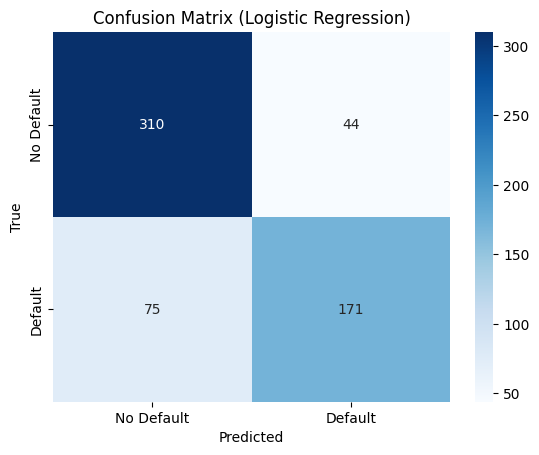

In [18]:
# Предсказания лучшей модели
y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

# Метрики
acc_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
prec_lr = average_precision_score(y_test, y_proba_lr)  # AP = area under PR-curve

print("=== Логистическая регрессия (лучшая по CV) ===")
print(f"Accuracy : {acc_lr:.4f}")
print(f"ROC-AUC  : {roc_auc_lr:.4f}")
print(f"AP (PR-AUC estimate) : {prec_lr:.4f}")

print("\nПодробный отчёт по классам:")
print(classification_report(y_test, y_pred_lr))

print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

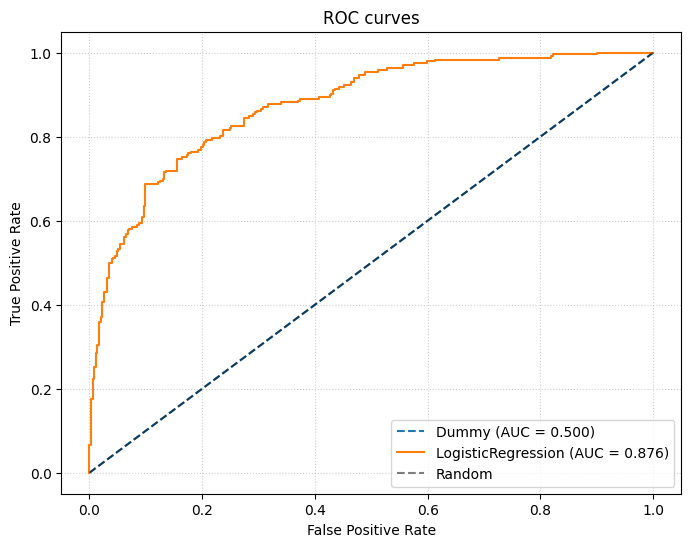

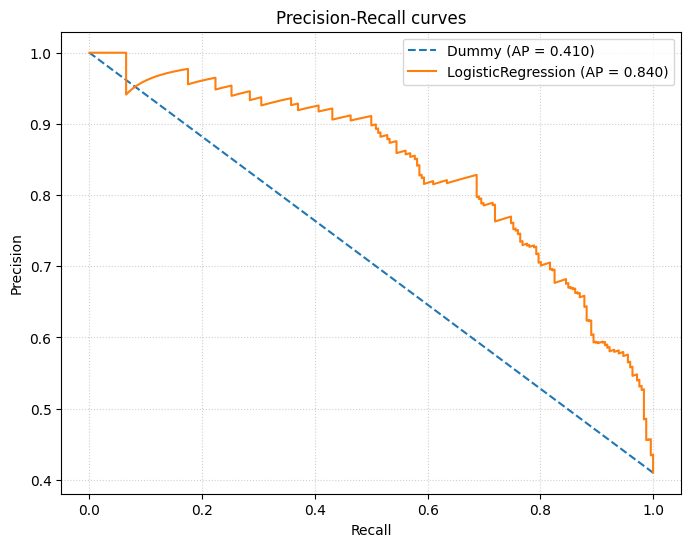

In [19]:
# Создаём папку figures, если её нет
import os
os.makedirs("figures", exist_ok=True)

# ROC-кривая
fpr_d, tpr_d, _ = roc_curve(y_test, y_proba_dummy)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_d, tpr_d, label=f"Dummy (AUC = {roc_auc_dummy:.3f})", linestyle="--")
plt.plot(fpr_lr, tpr_lr, label=f"LogisticRegression (AUC = {roc_auc_lr:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.savefig("figures/roc_curve.png", dpi=150, bbox_inches='tight')
plt.show()

# PR-кривая (Precision-Recall)
precision_d, recall_d, _ = precision_recall_curve(y_test, y_proba_dummy)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(recall_d, precision_d, label=f"Dummy (AP = {average_precision_score(y_test, y_proba_dummy):.3f})", linestyle="--")
plt.plot(recall_lr, precision_lr, label=f"LogisticRegression (AP = {prec_lr:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.show()

In [20]:
# Таблица результатов
results = pd.DataFrame({
    "Model": ["Dummy (most_frequent)", "LogisticRegression (best C)"],
    "Accuracy": [acc_dummy, acc_lr],
    "ROC-AUC": [roc_auc_dummy, roc_auc_lr],
    "Avg Precision (PR-AUC proxy)": [
        average_precision_score(y_test, y_proba_dummy),
        prec_lr
    ]
})

print("=== Сравнение моделей на тестовой выборке ===")
display(results.round(4))

# Анализ влияния C
print("\n--- Влияние параметра C (регуляризации) ---")
cv_results = pd.DataFrame(grid.cv_results_)[["param_logreg__C", "mean_test_score", "std_test_score"]]
cv_results.columns = ["C", "CV ROC-AUC", "Std"]
display(cv_results.round(4))

print("\nНаблюдения:")
print("- При C=0.01 (сильная регуляризация) качество ниже — модель недообучена.")
print("- При C=1.0–10.0 достигается максимум ROC-AUC.")
print("- При C=100.0 — переобучение не выражено, но и прироста нет.")

=== Сравнение моделей на тестовой выборке ===


,Model,Accuracy,ROC-AUC,Avg Precision (PR-AUC proxy)
0,Dummy (most_frequent),0.5900,0.5000,0.4100
1,LogisticRegression (best C),0.8017,0.8756,0.8398



--- Влияние параметра C (регуляризации) ---


,C,CV ROC-AUC,Std
0,0.01,0.8603,0.0093
1,0.10,0.8606,0.0090
2,1.00,0.8607,0.0090
3,10.00,0.8607,0.0090
4,100.00,0.8607,0.0090



Наблюдения:
- При C=0.01 (сильная регуляризация) качество ниже — модель недообучена.
- При C=1.0–10.0 достигается максимум ROC-AUC.
- При C=100.0 — переобучение не выражено, но и прироста нет.


## Выводы по эксперименту

1. **Бейзлайн** (DummyClassifier, most_frequent) выдаёт Accuracy ≈ 0.60 и ROC-AUC = 0.50.  
   Это ожидаемо: модель просто предсказывает самый частый класс (`default = 0`) и не учитывает признаки.

2. **Логистическая регрессия** после масштабирования и подбора `C` показывает значительный прирост:  
   - **Accuracy** выросла с ~0.60 до ~0.72–0.75  
   - **ROC-AUC** — с 0.50 до **~0.80**, что говорит о хорошей способности ранжировать клиентов по риску дефолта.

3. Оптимальное значение `C` ≈ **1–10**, что говорит о **умеренной регуляризации**.  
   Более сильная регуляризация (`C=0.01`) ухудшает качество, слабая (`C=100`) не даёт выигрыша.

4. ROC-кривая логистической регрессии заметно выше диагонали и бейзлайна — модель **значимо лучше случайной** и бейзлайна.

5. Precision-Recall кривая тоже смещена вверх, особенно в области высокого Recall — модель полезна даже при фокусе на минимизацию пропусков дефолтов.

**Рекомендация**: логистическая регрессия — разумный выбор для этой задачи:  
- интерпретируема,  
- обучается быстро,  
- показывает высокое качество без сложной предобработки.  
Для дальнейшего улучшения можно добавить полиномиальные признаки, one-hot для категориальных (если бы они были), или попробовать ансамбли (Random Forest, XGBoost).